In [1]:
import torch
import torch.nn as nn
import os
import numpy as np

class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(64),
                    )
        self.conv2 = nn.Sequential(
                        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                    )
        self.conv3 = nn.Sequential(
                        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                    )
        self.conv4 = nn.Sequential(
                        nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding=2),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                    )

        self.fc1 = nn.Linear(1024//8*256, sample_num)
        
    def forward(self, x):
        
        x = x.unsqueeze(1)
        x = x.to(torch.float32)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        
        return x

/home/visitor/anaconda3/envs/1DCNN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
import numpy as np

device = torch.device("cuda")
sample_num = 15
models = OneDCNN()
models.load_state_dict(torch.load("save/model_1DCNN_MIX.pth"))
cnn = models.to(device).eval()

content_layers_default = ['conv_3']
style_layers_default = ['conv_1','conv_2']

u = 0  
sig = math.sqrt(0.2)  
x = np.linspace(u - 3 * sig, u + 3 * sig, 2048)
y_sig = np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (math.sqrt(2 * math.pi) * sig)
pos_mat = []
for i in range(1024):
    pos_mat.append(y_sig[1024-i:2048-i])
pos_mat = torch.from_numpy(np.array(pos_mat)).to(device, torch.float)

import torch.nn.functional as F

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

G_counter = 0

def gram_matrix(input, pow_mat):
    global G_counter
    a, b, c = input.size()  # a=batch size(=1)

    features = input.view(a * b, c)  # resise F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product

    return G.div(a * b * c)

class StyleLoss(nn.Module):

    def __init__(self, target_feature, pow_mat):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature, pow_mat).detach()
        self.pow_mat = pow_mat

    def forward(self, input):
        # print("forwarding")
        G = gram_matrix(input, self.pow_mat)
        self.loss = F.mse_loss(G, self.target)
        return input

In [3]:
def get_style_model_and_losses(cnn, style_imgs, content_img, pow_mat,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    # normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential()

    i = 0  # increment every time we see a conv
    for layer0 in cnn.children():
        if isinstance(layer0, nn.Sequential):
            for layer in layer0.children():
                if isinstance(layer, nn.Conv1d):
                    i += 1
                    name = 'conv_{}'.format(i)
                elif isinstance(layer, nn.ReLU):
                    name = 'relu_{}'.format(i)
                    # The in-place version doesn't play very nicely with the ContentLoss
                    # and StyleLoss we insert below. So we replace with out-of-place
                    # ones here.
                    layer = nn.ReLU(inplace=False)
                elif isinstance(layer, nn.MaxPool1d):
                    name = 'pool_{}'.format(i)
                elif isinstance(layer, nn.BatchNorm1d):
                    name = 'bn_{}'.format(i)
                elif isinstance(layer, nn.Linear):
                    name = 'ln_{}'.format(i)
                else:
                    raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
                    
                model.add_module(name, layer)
        
                # print(model)
                # print(style_img.shape)
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).detach()
                    content_loss = ContentLoss(target)
                    model.add_module("content_loss_{}".format(i), content_loss)
                    content_losses.append(content_loss)

                for k in range(len(style_imgs)):
                    if name in content_layers:
                        # add content loss:
                        target = model(style_imgs[k]).detach()
                        content_loss = ContentLoss(target)
                        model.add_module("content_loss_{}_{}".format(k, i), content_loss)
                        content_losses.append(content_loss)
                    if name in style_layers and k ==0 :
                        # add style loss:
                        target_feature = model(style_imgs[k]).detach()
                        style_loss = StyleLoss(target_feature, pow_mat)
                        model.add_module("style_loss_{}_{}".format(k, i), style_loss)
                        style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [4]:

import torch.optim as optim
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [5]:

def run_style_transfer(cnn, content_img, style_imgs, input_img, pow_mat, num_steps=20,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
#     print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_imgs, content_img, pow_mat)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)

    old_loss = [-1] 
    new_loss = [0]
#     print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            # print("actual calculating")
            model(input_img)
            style_score = 0
            content_score = 0
            
            power = 1
            
            for sl in style_losses:
                style_score += sl.loss * power
                if power == 1:
                    power = 0.2
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score

            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))   
                new_loss[0] = style_score.item() + content_score.item()

            return style_score + content_score

        optimizer.step(closure)

        old_loss[0] = new_loss[0]
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, new_loss[0]

In [6]:

from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, dirs):
        self.x = None
        self.y = None
        for data_dir in dirs:
            f_list = os.listdir(data_dir)
            for idx in range(min(sample_num, len(f_list))):
                if self.x is None:
                    self.x = np.load(data_dir + str(idx+1) + '.npy')[:, :]
                else:
                    self.x = np.concatenate((self.x, np.load(data_dir + str(idx+1) + '.npy')[:, :]))
                tempy = np.zeros((200, sample_num))
                tempy[:, idx] = 1
                if self.y is None:
                    self.y = tempy
                else:
                    self.y = np.concatenate((self.y, tempy))

        # print(self.y.shape)
        # print(self.y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y


In [7]:
def tensor2np(image):
    image = image.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0).squeeze(0)      # remove the fake batch dimension
    return image.detach().numpy().astype(np.float64)

def calculate_power_mat(image_data):
    rtn_matrix = []
    for i in range(len(image_data)):
        rtn_matrix.append(image_data - np.roll(image_data,-i))
        # print(image_data - np.roll(image_data,-i))
    rtn_matrix = np.array(rtn_matrix)
    rtn_matrix = abs(rtn_matrix.T)
    for i in range(len(image_data)):
        rtn_matrix[i] = np.roll(rtn_matrix[i], i)
    rtn_matrix = rtn_matrix / rtn_matrix.max()
    return 1-rtn_matrix.T


In [27]:

import random
from PIL import Image
import time
import matplotlib.pyplot as plt
from torch.fft import rfftn

def do_style_transfer(from_dataset, to_dataset, weight_style, steps, result_dir, seed = 0):
    
    
    weight_style = float(weight_style)
    output_list = []
    for idx_sample in range(5, 6):
        ite = 0
        fail_times = 0
        while ite < 1:
            if True:
                sample = from_dataset[idx_sample * 200 + ite][0]
                pow_mat = torch.from_numpy(calculate_power_mat(sample)).to(device, torch.float)
                content_img = torch.from_numpy(sample).unsqueeze(0).unsqueeze(0).to(device, torch.float)

                style_images = []

                random.seed(time.time())

                for i in range(1):
                    idx = random.randint(0,199)
                    style_images.append(torch.from_numpy(to_dataset[(idx_sample) * 200 + idx][0]).unsqueeze(0).unsqueeze(0).to(device, torch.float))

                # input_img = content_img.clone()
                input_img = torch.from_numpy(np.random.rand(1, 1024)).unsqueeze(0).to(device, torch.float)
                input_for_show = input_img.clone()

                inputs = tensor2np(content_img)

                output, final_loss = run_style_transfer(cnn, content_img, style_images, input_img, pow_mat, style_weight=weight_style, num_steps=steps)

                fail_times += 1
                output = tensor2np(output)
                # Filter invaild data
                if (final_loss < 0.16 - idx_sample * 0.002) or fail_times > 3:
                    ite +=1
                    if fail_times < 3:
                        output_list.append(output)
                    else:
                        output_list.append(tensor2np(style_images[0]))
                    fail_times = 0
                print(final_loss)
                if ite % 10 == 0:
                    print("{}:{}".format(idx_sample, ite))
            else:
                output_list.append(temp[ite])
                ite +=1
            # print(output_list[0].shape)
        
        np.save(result_dir.format(idx_sample+1), np.asarray(output_list))
        
        output_list = []
            
    plt.rc('font',family='Times New Roman')
    plt.rcParams.update({"font.size":20})
    f, axarr = plt.subplots(1, 4, figsize = (25,5))
    # plt.rcParams['font.sans-serif']
    # [axi.set_axis_off() for axi in axarr.ravel()]
    plt.subplots_adjust(wspace =0.15, hspace =0.12)
    # plt.rcParams.update({'font.size': 16})
    
    axarr[0].set_title('Sample $T$')
    axarr[0].plot(np.arange(420,780,0.36), inputs[:1000])
    axarr[0].set_xlim(400,800)
    axarr[0].set_ylabel('Intensity (normalized)')
    axarr[1].set_title('Sample $S$')
    axarr[1].plot(np.arange(420,780,0.36), tensor2np(style_images[0])[:1000])
    axarr[1].set_xlim(400,800)
    # print(tensor2np(style_imgs))
    axarr[2].set_title('Sample $G$')
    axarr[2].plot(np.arange(420,780,0.36), output[:1000])
    axarr[2].set_xlim(400,800)
    # print(tensor2np(output))
    # axarr[3].set_title('Style difference')
    # axarr[3].plot(output - inputs)
    
    return inputs, tensor2np(style_images[0]), output

run [50]:
Style Loss : 0.022027 Content Loss: 0.406475
run [100]:
Style Loss : 0.001325 Content Loss: 0.083716
run [150]:
Style Loss : 0.000777 Content Loss: 0.068480
run [200]:
Style Loss : 0.000627 Content Loss: 0.067625
0.06825212278636172


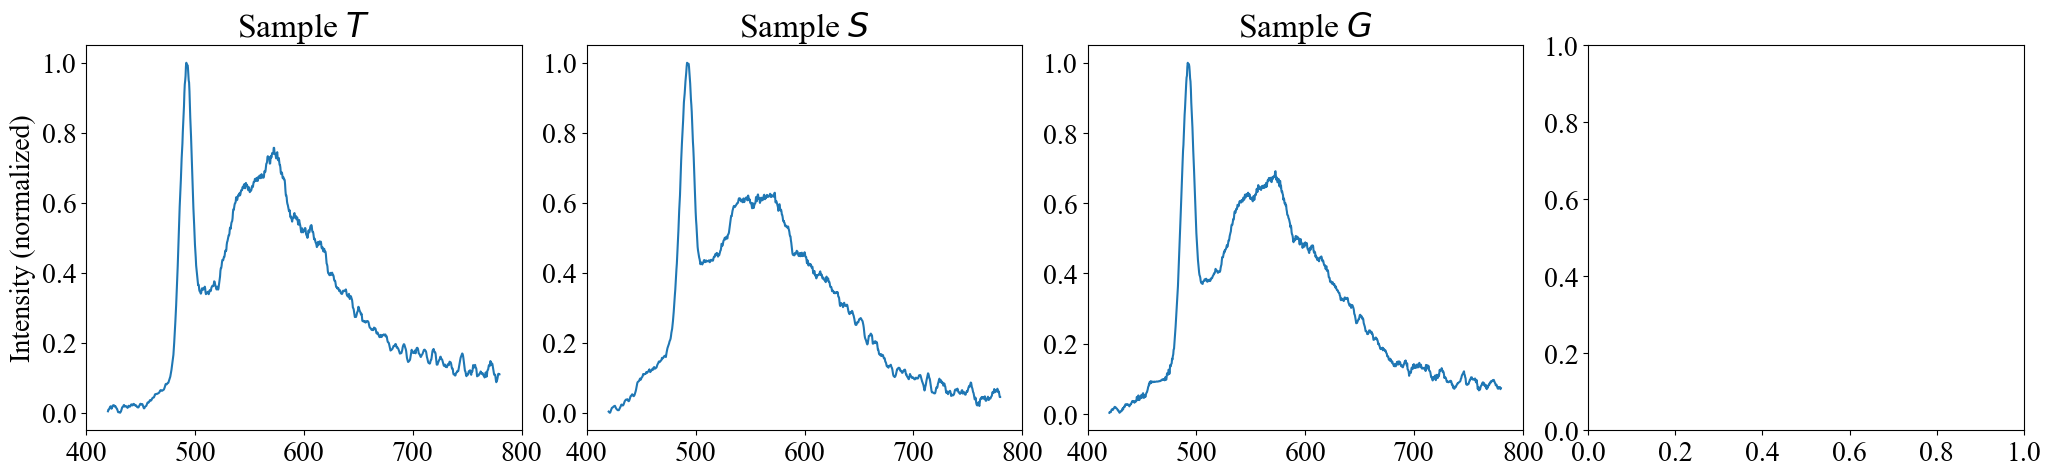

In [28]:

G_counter = 0
# from_dataset = MyDataset(['data/bg_npy/'])
# to_dataset = MyDataset(['data/clean_npy/'])
# content_gaussian, style_gaussian, output_gaussian = do_style_transfer(from_dataset, to_dataset, '200000', 60, 'data/temp/{}')
from_dataset = MyDataset(['data/clean_npy/'])
to_dataset = MyDataset(['data/noisy_npy/'])
content_gaussian, style_gaussian, output_gaussian = do_style_transfer(from_dataset, to_dataset, '200000', 200, 'data/t/{}')

In [126]:
calculate_power_mat(np.array([1,3,5,7,9])) * calculate_power_mat(np.array([1,3,5,7,9]))

array([[1.    , 0.5625, 0.25  , 0.0625, 0.    ],
       [0.5625, 1.    , 0.5625, 0.25  , 0.0625],
       [0.25  , 0.5625, 1.    , 0.5625, 0.25  ],
       [0.0625, 0.25  , 0.5625, 1.    , 0.5625],
       [0.    , 0.0625, 0.25  , 0.5625, 1.    ]])

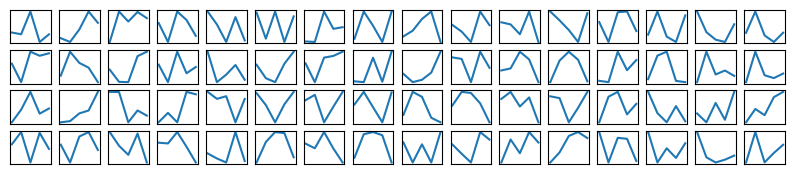

In [76]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.axis('off')
fig,ax=plt.subplots(4,16, figsize=(10,2))

weights_keys = models.state_dict().keys()
for key in weights_keys:
    # remove num_batches_tracked para(in bn)
    if "num_batches_tracked" in key:
        continue
    # [kernel_number, kernel_channel, kernel_height, kernel_width]
    weight_t = models.state_dict()[key].squeeze(1).cpu().clone().detach().numpy().astype(np.float64)
    # print(weight_t)
    for i in range(64):
        feature = weight_t[i]
        ax[i//16][i%16].plot(feature)
        ax[i//16][i%16].set_yticks([])
        ax[i//16][i%16].set_xticks([])
    break
plt.show()